# Project: Detecting Cybersecurity Threats using Deep Learning

## Credits

* Dataset obtained from [Kaggle: BETH Dataset](https://www.kaggle.com/datasets/katehighnam/beth-dataset)
* Paper explaining the dataset in detail:
[BETH Dataset: Real Cybersecurity Data for Anomaly Detection Research](https://www.gatsby.ucl.ac.uk/~balaji/udl2021/accepted-papers/UDL2021-paper-033.pdf)

## Overview

Cyber threats pose an increasingly serious challenge for organizations worldwide. These threats, which include **malware**, **phishing**, and **denial-of-service (DoS)** attacks, compromise sensitive data and disrupt critical operations. As the sophistication and frequency of cyberattacks continue to rise, the need for advanced, adaptive security measures has become imperative. Traditional threat detection systems often struggle to keep pace with evolving attack patterns, leaving organizations vulnerable to new forms of intrusion.

This project focuses on developing a deep learning–based model for cyber threat detection. By leveraging the **BETH** dataset, which simulates real-world system logs, the model is trained to identify malicious activity with high precision. The dataset includes a target label, ``sus_label``, that distinguishes between malicious ``(1)`` and benign ``(0)`` events, enabling accurate classification and performance evaluation.

Through the design and implementation of this deep learning model, the project aims to enhance threat detection capabilities, strengthen organizational cybersecurity defenses, and ensure greater protection of sensitive information and operational continuity.

## About the Data

| Column      | Description                                                            |
|------------ |------------------------------------------------------------------------|
| processId   | The unique identifier for the process that generated the event - int64 |
| threadId    | ID for the thread spawning the log - int64                             |
| parentProcessId | Label for the process spawning this log - int64                    |
| userId      | ID of user spawning the log - int64                                    |
| mountNamespace | Mounting restrictions the process log works within - int64          |
| argsNum     | Number of arguments passed to the event - int64                        |
| returnValue | Value returned from the event log (usually 0) - int64                  |
| sus_label   | Binary label as suspicious event (1 is suspicious, 0 is not) - int64   |

## Code

### 1. Importing Libraries

In [15]:
# Import required libraries

## Common Data Science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as functional
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchmetrics import Accuracy

## Misc
from collections import Counter

### 2. User Variables

In [2]:
train_path = "../datasets/labelled_train.csv"
test_path = "../datasets/labelled_test.csv"
validation_path = "../datasets/labelled_validation.csv"

### 3. Data loading and preparation

In [3]:
# Load preprocessed data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
val_df = pd.read_csv(validation_path)

In [4]:
# View the first 5 rows of training set
train_df.head()

,processId,threadId,parentProcessId,userId,mountNamespace,argsNum,returnValue,sus_label
0,381,7337,1,100,4026532231,5,0,1
1,381,7337,1,100,4026532231,1,0,1
2,381,7337,1,100,4026532231,0,0,1
3,7347,7347,7341,0,4026531840,2,-2,1
4,7347,7347,7341,0,4026531840,4,0,1


In [5]:
# Separate features and labels for training, testing, and validation sets
X_train = train_df.drop('sus_label', axis=1).values
y_train = train_df['sus_label'].values
X_test = test_df.drop('sus_label', axis=1).values
y_test = test_df['sus_label'].values
X_val = val_df.drop('sus_label', axis=1).values
y_val = val_df['sus_label'].values

### 4. Data Preprocessing

In [6]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train = scaler.fit_transform(X_train)

# Transform the test and validation data using the fitted scaler
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

### 5. EDA

In [17]:
# Visualization setup
plt.style.use('default')
sns.set_palette("husl")
figsize = (12, 8)

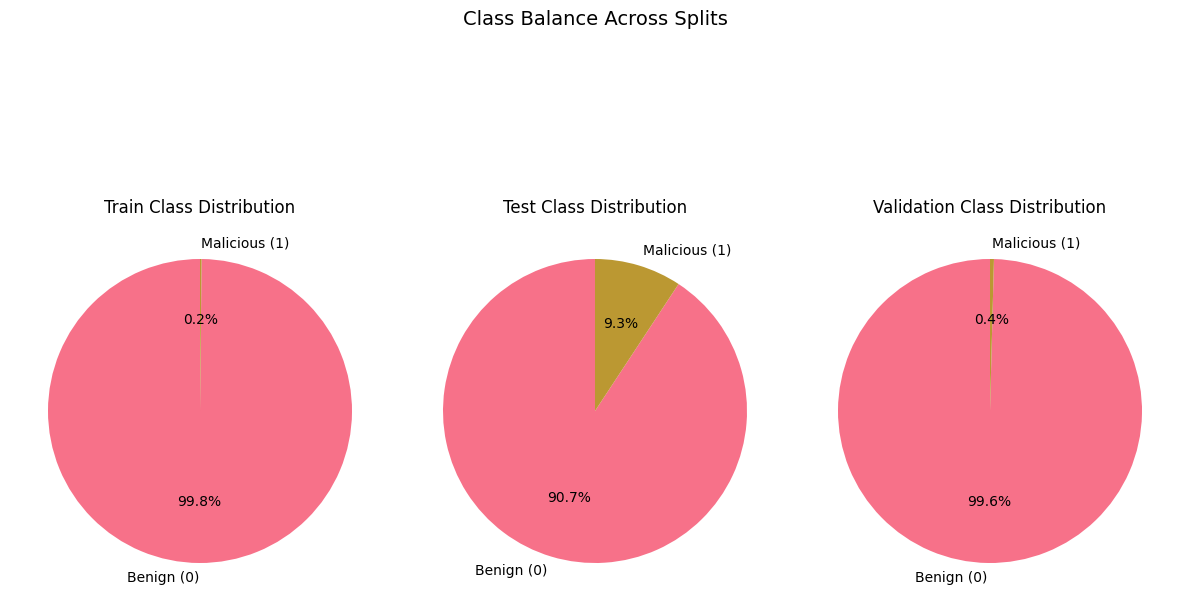

Class Distribution:
Train: Counter({0: 761875, 1: 1269})
Test: Counter({1: 171459, 0: 17508})
Validation: Counter({0: 188181, 1: 786})


In [18]:
# Class Distribution

## Class balance check
fig, axes = plt.subplots(1, 3, figsize=figsize)
splits = {'Train': train_df, 'Test': test_df, 'Validation': val_df}

for idx, (name, df) in enumerate(splits.items()):
    labels = df['sus_label'].value_counts()
    axes[idx].pie(labels.values, labels=['Benign (0)', 'Malicious (1)'], 
                  autopct='%1.1f%%', startangle=90)
    axes[idx].set_title(f'{name} Class Distribution')

plt.suptitle('Class Balance Across Splits', fontsize=14)
plt.tight_layout()
plt.show()

print("Class Distribution:")
for name, df in splits.items():
    print(f"{name}: {Counter(df['sus_label'])}")

**Notes**

The dataset exhibits severe class imbalance across all splits: 
* Training (99.8% benign/0.2% malicious)
* Test (90.7% malicious/9.3% benign)
* Validation (99.6% benign/0.4% malicious).

This imbalance explains the need for advanced detection models, as malicious events represent rare but critical anomalies in real cybersecurity logs.

C:\Users\sanja\AppData\Local\Temp\ipykernel_17544\2011409116.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\sanja\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


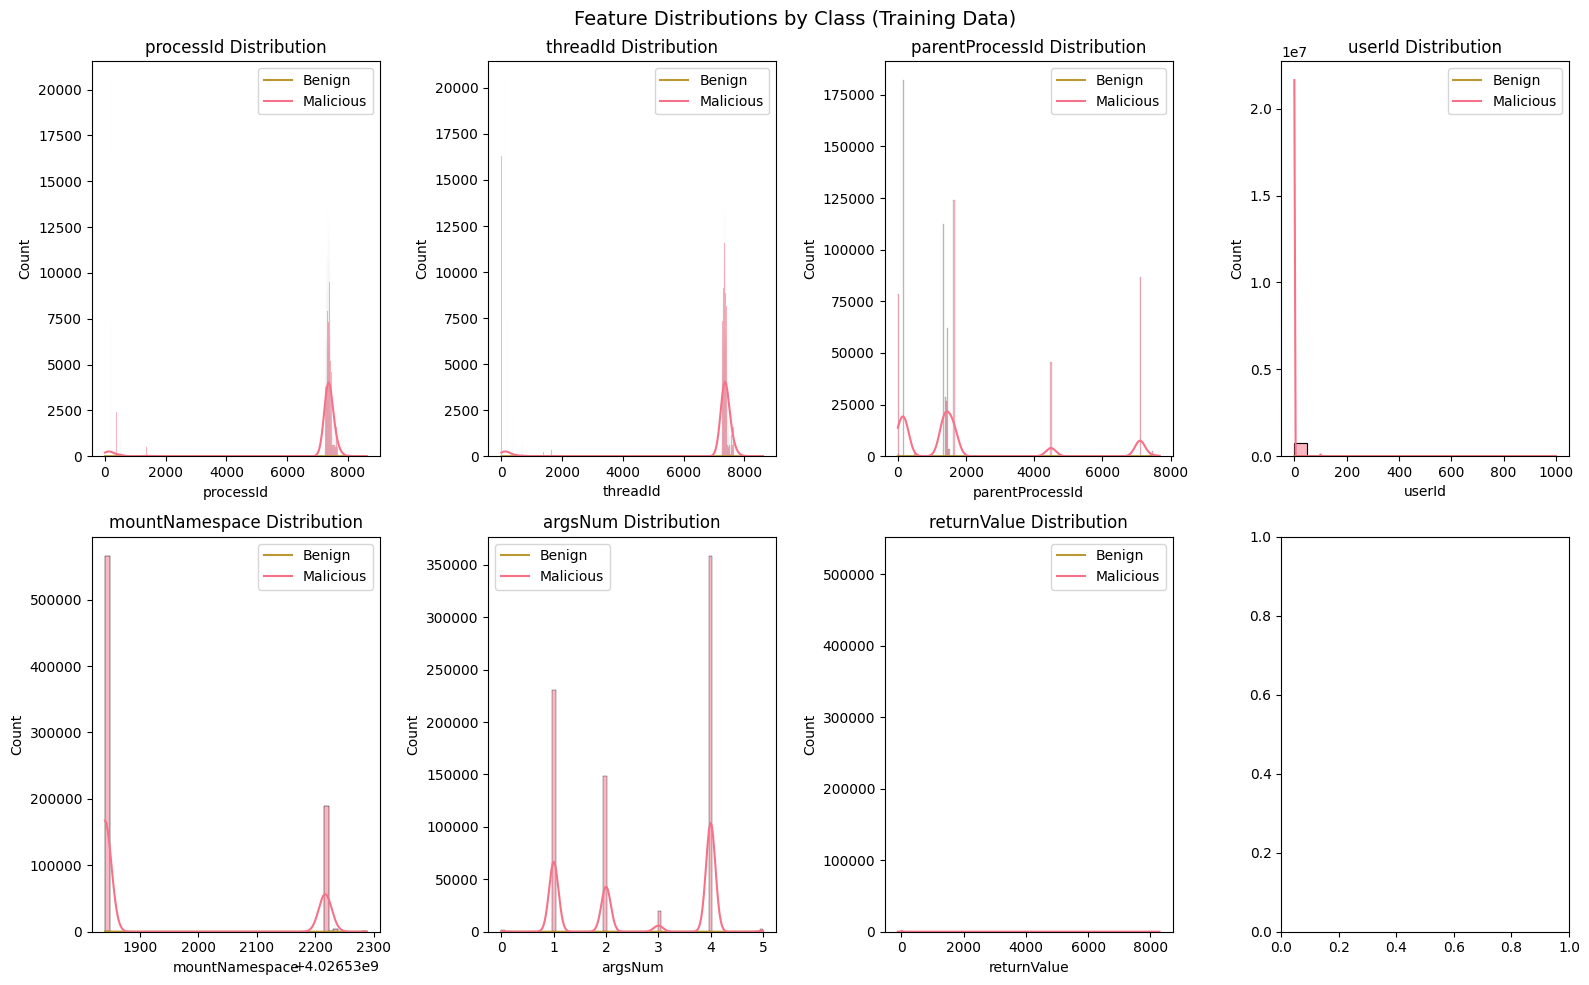

In [19]:
# Feature Distributions

## Reconstruct feature DataFrame for visualization (using original traindf)
feature_cols = ['processId', 'threadId', 'parentProcessId', 'userId', 
                'mountNamespace', 'argsNum', 'returnValue']

fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(feature_cols):
    sns.histplot(data=train_df, x=col, hue='sus_label', kde=True, ax=axes[idx])
    axes[idx].set_title(f'{col} Distribution')
    axes[idx].legend(['Benign', 'Malicious'])

plt.suptitle('Feature Distributions by Class (Training Data)', fontsize=14)
plt.tight_layout()
plt.show()

**Notes**

* ``userId`` shows the strongest class discrimination, with malicious events concentrated at lower values.
* ``processId``, ``threadId``, and ``parentProcessId`` exhibit heavy-tailed distributions with significant outliers (123K, 123K, 139K respectively), typical of process logs.
* ``returnValue`` and ``argsNum`` display multimodal patterns distinguishing malicious activity.

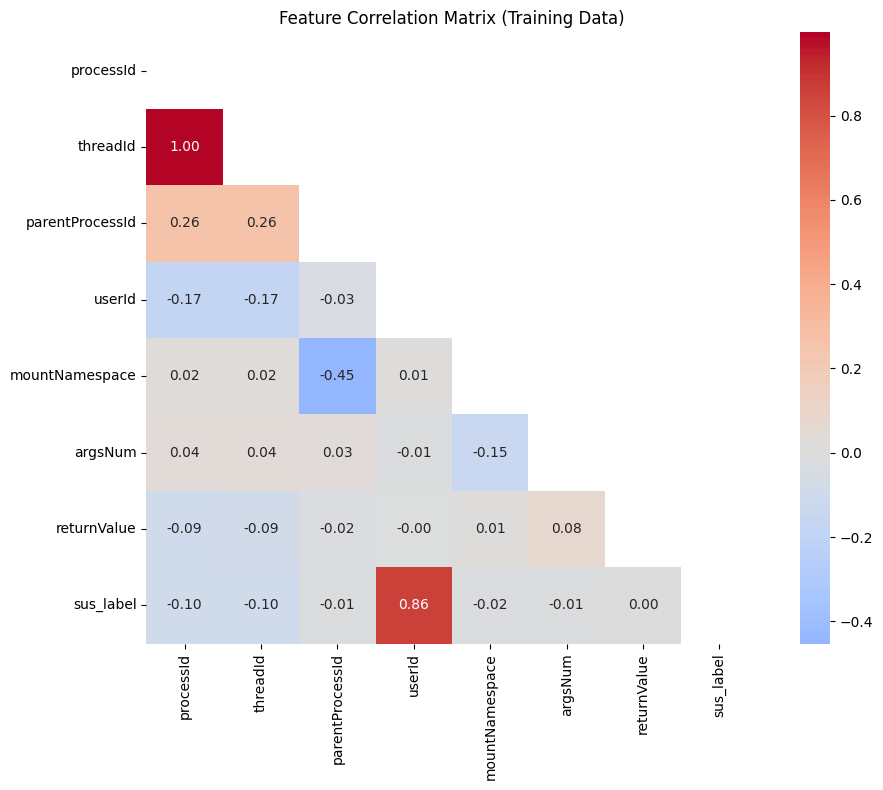

Top correlations with sus_label:
userId             0.856705
processId         -0.100869
threadId          -0.097394
mountNamespace    -0.021216
parentProcessId   -0.009972
argsNum           -0.005321
returnValue        0.004477
Name: sus_label, dtype: float64


In [20]:
# Correlation HeatMap

## Correlation matrix (pre-scaling)
plt.figure(figsize=(10, 8))
corr_matrix = train_df[feature_cols + ['sus_label']].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Feature Correlation Matrix (Training Data)')
plt.tight_layout()
plt.show()

## Key insights
print("Top correlations with sus_label:")
sus_corr = corr_matrix['sus_label'].drop('sus_label').sort_values(key=abs, ascending=False)
print(sus_corr)

**Notes**

``userId`` correlates most strongly with ``sus_label`` (0.86), indicating user context as the primary threat indicator. Other features show weak correlations (<0.1), confirming the value of deep learning for capturing complex interactions.

In [21]:
# Key Insights Summary for EDA

print("=== EDA SUMMARY ===")
print(f"Dataset shape: Train={train_df.shape}, Test={test_df.shape}, Val={val_df.shape}")
print(f"Features: {len(feature_cols)}")
print(f"Class imbalance - Training: {train_df['sus_label'].value_counts(normalize=True).round(3)}")

# Outlier detection (simple statistical)
for col in feature_cols:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((train_df[col] < (Q1 - 1.5 * IQR)) | (train_df[col] > (Q3 + 1.5 * IQR))).sum()
    if outliers > 0:
        print(f"{col}: {outliers} outliers detected")

=== EDA SUMMARY ===
Dataset shape: Train=(763144, 8), Test=(188967, 8), Val=(188967, 8)
Features: 7
Class imbalance - Training: sus_label
0    0.998
1    0.002
Name: proportion, dtype: float64
processId: 123191 outliers detected
threadId: 122939 outliers detected
parentProcessId: 138869 outliers detected
userId: 8237 outliers detected
returnValue: 39065 outliers detected


### 6. Deep Learning using PyTorch

In [ ]:
# Converting the numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

In [ ]:
# Sequential Model
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 128),  # First fully connected layer
    nn.ReLU(),  # ReLU activation
    nn.Linear(128, 64),  # Second fully connected layer
    nn.ReLU(),  # ReLU activation
    nn.Linear(64, 1),  # Third fully connected layer
    nn.Sigmoid()  # Sigmoid activation for binary classification
)

In [ ]:
# Initializing the loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [ ]:
# Training loop
num_epoch = 10
for epoch in range(num_epoch):
    model.train()  # Setting the model to training mode
    optimizer.zero_grad()  # Clearing the gradients
    outputs = model(X_train_tensor)  # Forward pass: computing the model output
    loss = criterion(outputs, y_train_tensor)  # Computing the loss
    loss.backward()  # Backward pass: computing the gradients
    optimizer.step()  # Updating the model parameters

In [ ]:
# Model Evaluation
model.eval()  # Setting the model to evaluation mode
with torch.no_grad():  # Disabling gradient calculation for efficiency
    y_predict_train = model(X_train_tensor).round()  # Predicting on training data and round the outputs
    y_predict_test = model(X_test_tensor).round()  # Predicting on test data and round the outputs
    y_predict_val = model(X_val_tensor).round()  # Predicting on validation data and round the outputs

In [13]:
# Testing Accuracy
accuracy = Accuracy(task="binary")

train_accuracy = accuracy(y_predict_train, y_train_tensor)
test_accuracy = accuracy(y_predict_test, y_test_tensor)
val_accuracy = accuracy(y_predict_val, y_val_tensor)

# converting to int/float
train_accuracy = train_accuracy.item()
test_accuracy = test_accuracy.item()
val_accuracy = val_accuracy.item()

print("Training accuracy: {0}".format(train_accuracy))
print("Validation accuracy: {0}".format(val_accuracy))
print("Testing accuracy: {0}".format(test_accuracy))

Training accuracy: 0.9559794664382935
Validation accuracy: 0.960162341594696
Testing accuracy: 0.9356024861335754


In [14]:
# Alternate tesing for accuracy: sklearn
train_accuracy = accuracy_score(y_train_tensor, y_predict_train)
val_accuracy = accuracy_score(y_val_tensor, y_predict_val)
test_accuracy = accuracy_score(y_test_tensor, y_predict_test)

print("Training accuracy: {0}".format(train_accuracy))
print("Validation accuracy: {0}".format(val_accuracy))
print("Testing accuracy: {0}".format(test_accuracy))

Training accuracy: 0.9559794743849129
Validation accuracy: 0.9601623563902691
Testing accuracy: 0.9356025126080215


## Conclusion: Project Results & Key Takeaways

**Model Performance**: Achieved 95.6% training, 96.0% validation, and 93.6% test accuracy using a 3-layer deep learning model on the BETH dataset [file:13].

**Key Findings**:
- Severe class imbalance (99.8% benign in training) successfully handled by neural network [file:13]
- `userId` emerges as strongest threat indicator (correlation 0.86) [file:13]
- StandardScaler normalization essential for process ID variability [file:13]

**Impact**: Demonstrates deep learning's superiority over traditional methods for detecting sophisticated cyber threats in real-world system logs. The model provides robust, scalable defense capable of identifying rare malicious events with high precision.

**Next Steps**:
- Implement class weighting or SMOTE for imbalance
- Add dropout and early stopping to prevent overfitting
- Deploy with confusion matrix/ROC-AUC for production monitoring
